In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

In [2]:
workingDirectory = '/home/h1bennet/lxr/results/180817_DMHCA_diet/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

NameError: name 'os' is not defined

## define functions

In [4]:
# define function for labeling points in scatterplots
def label_point(x, y, val, ax, fontsize=12):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        # print(i, point)
        ax.text(point['x']+.02,
                point['y'],
                str(point['val']),
                fontsize=fontsize)

# QC

In [5]:
def ngs_qc(experiment):
    
    qc_dir = './qc_' + experiment
    tag_dir = './tag_directories_' + experiment + '/'

    if not os.path.isdir(qc_dir):
        os.mkdir(qc_dir)
    
    # make summary table of qc stats
    qc_stats = pd.DataFrame()

    for sample in os.listdir(tag_dir + '/'):
        # pull tag information from HOMER output file
        if any(fname.endswith('tagInfo.txt') for fname in os.listdir(tag_dir+sample+'/')):
            tag_info_df = pd.read_table(tag_dir+sample+'/tagInfo.txt', sep='\t')
            qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
            qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
            qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
            qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
            qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
        else:
            print(sample + ' had no aligned tags')
            qc_stats.loc[sample, 'uniquePositions'] = 0
            qc_stats.loc[sample, 'fragmentLengthEstimate'] = 0
            qc_stats.loc[sample, 'tagsPerBP'] = 0
            qc_stats.loc[sample, 'clonality'] = 0
            qc_stats.loc[sample, 'GC_Content'] = 0
        
        if experiment.lower() == 'rna':
            # pull star samples
            for file in os.listdir(tag_dir+sample+'/'):
                if file.endswith(".log"):
                    f = open(tag_dir+sample+'/'+file)
                    txt = f.read()
                    star_log = list(filter(None, re.split('\s|\|',txt)))
                    qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
                    qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
                    qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
                    qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
                    qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
                    qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
                    qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                            qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                            / qc_stats.loc[sample, 'totalReads']
                    qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                                    - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                                    - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                                    - qc_stats.loc[sample, 'totalReads']
        else:
            # pull bowtie samples
            for file in os.listdir(tag_dir+sample+'/'):
                if file.endswith(".log"):
                    f = open(tag_dir+sample+'/'+file)
                    bowtie_log = f.read().split()
                    qc_stats.loc[sample, 'totalReads'] = int(bowtie_log[0])
                    qc_stats.loc[sample, 'uniquelyMappedReads'] = int(bowtie_log[15])
                    qc_stats.loc[sample, 'multiMappedReads'] = int(bowtie_log[21])
                    qc_stats.loc[sample, 'unmappedReads'] = int(bowtie_log[10])
                    qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                                qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                                / qc_stats.loc[sample, 'totalReads']
                    qc_stats.loc[sample, 'mappedFraction'] = \
                                                        (qc_stats.loc[sample, 'totalReads'] \
                                                        - qc_stats.loc[sample, 'unmappedReads']) \
                                                        / qc_stats.loc[sample, 'totalReads']

                elif not any(fname.endswith('.log') for fname in os.listdir(tag_dir+sample+'/')):
                    print(sample + ' does not contain a mapping log file')
                    qc_stats.loc[sample, 'totalReads'] = 0
                    qc_stats.loc[sample, 'uniquelyMappedReads'] = 0
                    qc_stats.loc[sample, 'multiMappedReads'] = 0
                    qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = 0
                    qc_stats.loc[sample, 'frac_unmappedReads_short'] = 0
                    qc_stats.loc[sample, 'frac_unmappedReads_other'] = 0
                    qc_stats.loc[sample, 'uniquelyMappedFraction'] = 0
                    qc_stats.loc[sample, 'mappedFraction'] = 0
    
    qc_stats.sort_index(inplace=True)
    qc_stats.to_csv('./qc_' + experiment + '/mapping_stats.tsv', sep='\t')
    
    # make qc plots
    # clonality boxplot
    fig = sns.boxplot(y=qc_stats['clonality'].dropna()).get_figure()
    fig.savefig(qc_dir + '/clonality_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # clonality distplot
    fig = sns.distplot(qc_stats['clonality'].dropna()).get_figure()
    fig.savefig(qc_dir + '/clonality_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # GC_Content boxplot
    fig = sns.boxplot(y=qc_stats['GC_Content'].dropna()).get_figure()
    fig.savefig(qc_dir + '/GC_Content_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # mapped fraction boxplot
    fig = sns.boxplot(y=qc_stats['mappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/mappedFraction_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # mapped fraction distplot
    fig = sns.distplot(qc_stats['mappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/mappedFraction_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Fraction boxplot
    fig = sns.boxplot(y=qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedFraction_boxplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Fraction distplot
    fig = sns.distplot(qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedFraction_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Reads boxplot
    fig = sns.boxplot(y=qc_stats['uniquelyMappedReads'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    # uniquely Mapped Reads distplot
    fig = sns.distplot(qc_stats['uniquelyMappedReads'].dropna()).get_figure()
    fig.savefig(qc_dir + '/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')
    fig.clf()
    
    return qc_stats


In [4]:
atac_qc = ngs_qc('atac')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

In [5]:
atac_qc

,uniquePositions,fragmentLengthEstimate,tagsPerBP,clonality,GC_Content,totalReads,uniquelyMappedReads,multiMappedReads,unmappedReads,uniquelyMappedFraction,mappedFraction
C57B6J_Tim4PosKupffer_ATAC_AMLNDietDMHCA_7wk_6B,5715668.0,68.0,0.002678,1.277,-1.0,11517734.0,8467859.0,2796958.0,252917.0,0.735202,0.978041
C57B6J_Tim4PosKupffer_ATAC_AMLNDietDMHCA_8wk_6C,6472868.0,62.0,0.003198,1.346,-1.0,12018172.0,9412344.0,2371153.0,234675.0,0.783176,0.980473
C57B6J_Tim4PosKupffer_ATAC_AMLNDiet_7wk_4A,6456698.0,57.0,0.003352,1.415,-1.0,12057656.0,9598839.0,2200114.0,258703.0,0.796078,0.978545
C57B6J_Tim4PosKupffer_ATAC_AMLNDiet_7wk_4B,6921594.0,56.0,0.003253,1.281,-1.0,12283444.0,9610157.0,2360243.0,313044.0,0.782367,0.974515
C57B6J_Tim4PosKupffer_ATAC_AMLNDiet_8wk_4C,7169445.0,71.0,0.003354,1.275,-1.0,12127574.0,9330295.0,2568937.0,228342.0,0.769346,0.981172
C57B6J_Tim4PosKupffer_ATAC_ControlDietDMHCA_6wk_5A,6031056.0,56.0,0.003031,1.370,-1.0,11962195.0,8811859.0,2743074.0,407262.0,0.736642,0.965954
C57B6J_Tim4PosKupffer_ATAC_ControlDietDMHCA_6wk_5B,4735523.0,56.0,0.002326,1.339,-1.0,10310101.0,7427804.0,2619500.0,262797.0,0.720439,0.974511
C57B6J_Tim4PosKupffer_ATAC_ControlDietDMHCA_6wk_5C,5203318.0,56.0,0.002675,1.401,-1.0,11493025.0,8389462.0,2792008.0,311555.0,0.729961,0.972892
C57B6J_Tim4PosKupffer_ATAC_ControlDiet_6wk_3A,6740018.0,57.0,0.002859,1.156,-1.0,11878834.0,8362809.0,3064028.0,451997.0,0.704009,0.961949
C57B6J_Tim4PosKupffer_ATAC_ControlDiet_6wk_3B,5950236.0,56.0,0.002772,1.270,-1.0,11159182.0,8077828.0,2665258.0,416096.0,0.723873,0.962713


In [6]:
%%bash
if [ ! -d ./tag_directories_atac_excluded/ ]; then mkdir ./tag_directories_atac_excluded; fi
mv ./tag_directories_atac/C57B6J_Tim4PosKupffer_ATAC_AMLNDietDMHCA_8wk_6D ./tag_directories_atac_excluded/C57B6J_Tim4PosKupffer_ATAC_AMLNDietDMHCA_8wk_6D

mv: cannot stat ‘./tag_directories_atac/C57B6J_Tim4PosKupffer_ATAC_AMLNDietDMHCA_8wk_6D’: No such file or directory


# Call Peaks

In [7]:
%%bash
# delete the existing script file
rm ./peakCalling_homer.sh
# create a script file
touch ./peakCalling_homer.sh

# if directories don't exist, create them
if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi

In [8]:
with open('./peakCalling_homer.sh', 'w') as f:
    for tagdir in os.listdir('./tag_directories_atac/'):
        find_peaks_idr = ['findPeaks', './tag_directories_atac/' + tagdir,
                          '-L', '0', '-C', '0', '-fdr', '0.9', '-style',
                          'factor', '-size', '200', '>',
                          workingDirectory + '/atac_peak_files/' + tagdir + '_peaks.tsv',
                          '&', '\n']
        find_peaks = ['findPeaks', './tag_directories_atac/' + tagdir,
                      '-style', 'factor', '-size', '200', '>',
                      workingDirectory + '/atac_peak_files/' + tagdir + '_default_peaks.tsv',
                      '&', '\n']
        # write commands to file
        f.write(' '.join(find_peaks_idr))
        f.write(' '.join(find_peaks))

In [6]:
group_dict = {}
for tagdir in os.listdir('./tag_directories_atac'):
    group = tagdir.split('_')[3]
    group_dict[tagdir] = group
    
sample_groups = pd.DataFrame([group_dict.keys(),
                             group_dict.values()]).T
sample_groups.columns = ['tagdir', 'group']

# Run IDR

In [10]:
%%bash
# delete the existing script file
rm ./run_idr.sh
# create a script file
touch ./run_idr.sh

# if directories don't exist, create them
if [ ! -d ./atac_idr/ ]; then mkdir ./atac_idr; fi

In [1]:
import itertools
mylist = os.listdir('./tag_directories_atac/')
mylist.sort()
# use pattern to extract cell type
with open('./run_idr.sh', 'w') as f:
    for i, j in itertools.combinations(mylist, r=2):
        run_idr = ['python', '/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                             workingDirectory + '/atac_peak_files/' + i + '_peaks.tsv',
                             workingDirectory + '/atac_peak_files/' + j + '_peaks.tsv',
                             './atac_idr/', '-threshold', '0.01', '\n']
        m = [i.split('_')[3],
             j.split('_')[3]]
        # if same cell type and not same sample run idr on them
        if (m[0] == m[1]) & (i != j):
            # ('i:', i, 'j:', j)
            f.write(' '.join(run_idr))

NameError: name 'os' is not defined

# Run TBA

In [7]:
%%bash
# delete the existing script file
rm ./run_tba.sh
# create a script file
touch ./run_tba.sh

# if directories don't exist, create them
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi
if [ ! -d ./peak_sequences/ ]; then mkdir ./peak_sequences; fi
if [ ! -d ./background_files/ ]; then mkdir ./background_files; fi
if [ ! -d ./tba_output/ ]; then mkdir ./tba_output; fi

# for each peak file create several commands
for peak_file in ./atac_idr_peaks/*;

# generate name of bed file
do bed_file=${peak_file/tsv/bed};
bed_file=${bed_file/atac_idr_peaks/bed_files}
# call Homer pos2bed.pl to create bed file
echo "pos2bed.pl $peak_file > $bed_file" >> ./run_tba.sh

# generate peak sequence fasta file name
seq_file=${bed_file/peaks.bed/peaks.fasta};
seq_file=${seq_file/bed_files/peak_sequences};

# execute command to extract sequences
echo "/home/h1bennet/code/tba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_tba.sh

# generate background coordinates
echo "/home/h1bennet/code/tba/model_training/generate_background_coordinates.py $bed_file mm10 ./background_files/">> ./run_tba.sh

# rename background file
bg_seq_file=${seq_file/peak_sequences/background_files};
bg_seq_file=${bg_seq_file/peaks.fasta/background.fasta};
echo "mv ./background_files/background.fasta $bg_seq_file">> ./run_tba.sh
echo "/home/h1bennet/code/tba/model_training/create_features.py -num_procs 40 $seq_file $bg_seq_file ./tba_output /home/h1bennet/code/tba/default_motifs/*">> ./run_tba.sh

# calculate motif scores for peaks and background
combined_features=${seq_file/peak_sequences/tba_output}
combined_features=${combined_features/.fasta/_combined_features.tsv}
labels=${combined_features/combined_features.tsv/labels.txt}
echo "/home/h1bennet/code/tba/model_training/train_classifier.py $combined_features $labels ./tba_output/">> ./run_tba.sh
coeff_path=${combined_features/combined_features.tsv/coefficients.tsv}
performance_path=${combined_features/combined_features.tsv/performance.tsv}
echo "mv ./tba_output/coefficients.tsv $coeff_path">> ./run_tba.sh
echo "mv ./tba_output/performance.tsv $performance_path">> ./run_tba.sh

# perform insilico mutagenesis
echo "/home/h1bennet/code/tba/model_training/calc_feature_significance.py $combined_features $labels ./tba_output/ -num_iterations 1">> ./run_tba.sh
significance_path=${combined_features/combined_features.tsv/significance.tsv}
echo mv ./tba_output/significance.tsv $significance_path>> ./run_tba.sh

done

# Annotate Significance with Gene Name

In [8]:
%%bash
# label significance files with gene names
for sig_file in ./tba_output/*significance.tsv;
do sig_file_gene=${sig_file/significance.tsv/significance_name.tsv};
/home/h1bennet/code/tba/model_training/annotate_results_with_genes.py $sig_file $sig_file_gene;
done

for coef_file in ./tba_output/*coefficients.tsv;
do coef_file_gene=${coef_file/coefficients.tsv/coefficients_name.tsv};
/home/h1bennet/code/tba/model_training/annotate_results_with_genes.py $coef_file $coef_file_gene;
done

# Summary Figures

In [9]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

In [10]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f and not 'name' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:3])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

In [11]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f and not 'name' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:3])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


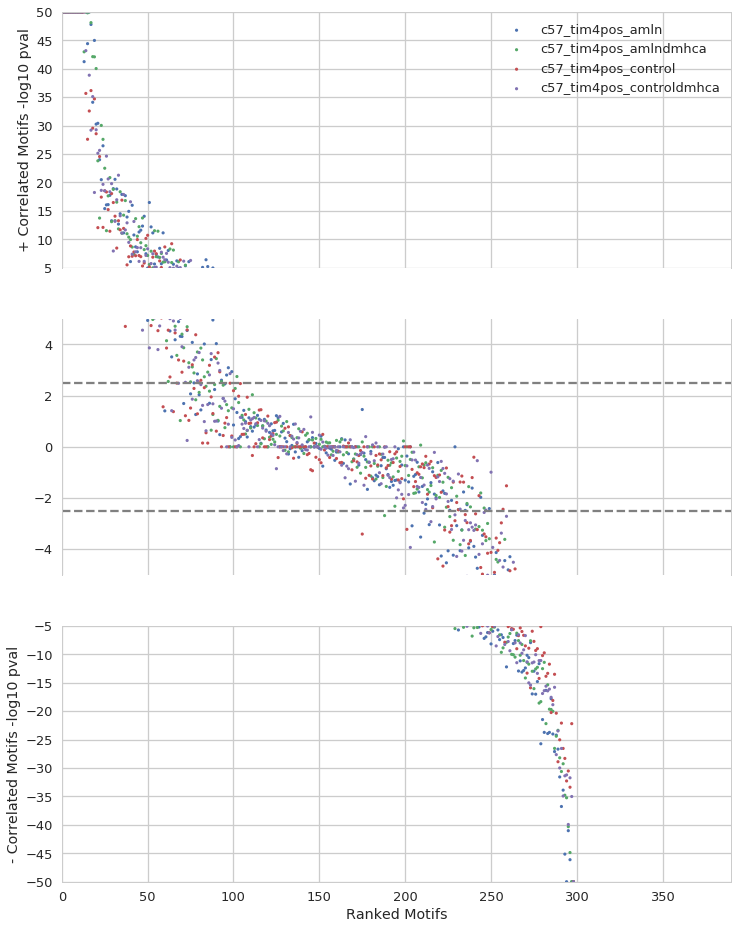

In [12]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette(n_colors=frame.shape[1])
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,390)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=390,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=390,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')

plt.savefig('./figures/summary_tba_splot.pdf',bbox_inches='tight')

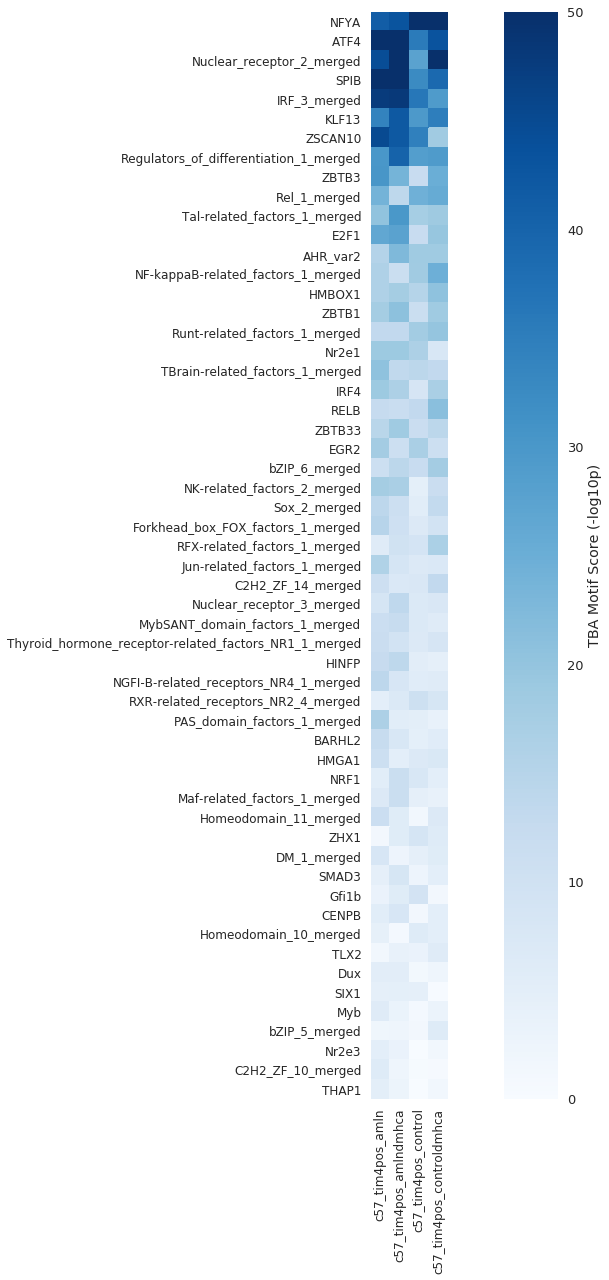

In [32]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals
    
# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]

# create heatmap
fig, ax = plt.subplots(figsize=(20,20))
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax,
     cbar_kws={'label':'TBA Motif Score (-log10p)'})
pos = hm.get_position()

hm.set_yticklabels(size=12, labels = filtered_frame.index.values);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);
plt.savefig('./figures/summary_tba_heatmap.pdf',bbox_inches='tight')

TypeError: __init__() got an unexpected keyword argument 'fontsize'

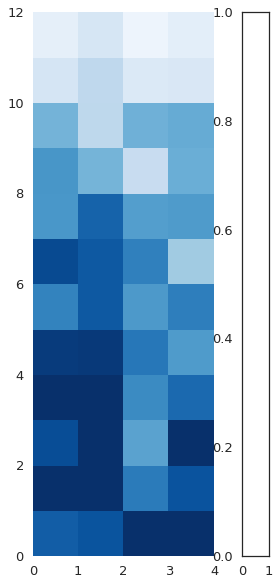

In [41]:
# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(filtered_frame.iloc[pd.np.r_[:10, 30, 44], :],
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax,
     cbar_kws={'label':'TBA Motif Score (-log10p)', 'fontsize':16})
pos = hm.get_position()

hm.set_yticklabels(size=16, labels = filtered_frame.iloc[pd.np.r_[:10, 30, 44], :].index.values);
hm.set_xticklabels(size=16, labels = filtered_frame.iloc[pd.np.r_[:10, 30, 44], :].columns.values, rotation=90);
plt.savefig('./figures/summary_tba_heatmap_abridged.pdf',bbox_inches='tight')

In [25]:
filtered_frame.loc['NF-kappaB-related_factors_1_merged']

c57_tim4pos_amln            16.058719
c57_tim4pos_amlndmhca       11.522591
c57_tim4pos_control         18.328979
c57_tim4pos_controldmhca    24.630943
Name: NF-kappaB-related_factors_1_merged, dtype: float64

* Off the top we see that the SMAD3 motif appears more significant with DMCHA treatment
* Nuclear_receptor_3_merged contains LXRa and LXRb and is significant. 
* NF-kappaB-related_factors significance is lower with DMHCA treatment